# Import Libraries

In [24]:
import import_ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle
import wandb


In [25]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor

# Import Preprocessed Data

In [26]:
df=pd.read_csv("C:\\Users\\nivet\\OneDrive\\Documents\\Dataset.csv", header=0, sep=',', encoding='Latin1',)

#  Label Encoding

In [27]:
df.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,24-03-2016 11:52,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,24-03-2016 00:00,0.0,70435.0,07-04-2016 03:16
1,24-03-2016 10:58,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,24-03-2016 00:00,0.0,66954.0,07-04-2016 01:46
2,14-03-2016 12:52,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,14-03-2016 00:00,0.0,90480.0,05-04-2016 12:47
3,17-03-2016 16:54,GOLF_4_1_4__3T RER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,17-03-2016 00:00,0.0,91074.0,17-03-2016 17:40
4,31-03-2016 17:25,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,31-03-2016 00:00,0.0,60437.0,06-04-2016 10:17


In [28]:
labels = ['gearbox', 'notRepairedDamage', 'model', 'brand', 'fuelType', 'vehicleType']

mapper = {}
for i in labels:
    mapper[i] = LabelEncoder()
    mapper[i].fit(df[i])
    tr = mapper[i].transform(df[i])
    np.save(str('classes'+i+'.npy'), mapper[i].classes_)
    df.loc[:, i+'_labels'] = pd.Series(tr, index=df.index)
    
labeled = df[['price', 'yearOfRegistration','powerPS','kilometer','monthOfRegistration']
                  +[x+"_labels" for x in labels]]

print(labeled.columns)

Index(['price', 'yearOfRegistration', 'powerPS', 'kilometer',
       'monthOfRegistration', 'gearbox_labels', 'notRepairedDamage_labels',
       'model_labels', 'brand_labels', 'fuelType_labels',
       'vehicleType_labels'],
      dtype='object')


# Different Metrics Evaluation

In [29]:
def find_scores(Y_actual, Y_pred, X_train):
    scores = dict()
    mae = mean_absolute_error(Y_actual, Y_pred)
    mse = mean_squared_error(Y_actual, Y_pred)
    rmse = np.sqrt(mse)
    rmsle = np.log(rmse)
    r2 = r2_score(Y_actual, Y_pred)
    n, k = X_train.shape
    adj_r2_score = 1 - ((1-r2)*(n-1)/(n-k-1))
    
    scores['mae']=mae
    scores['mse']=mse
    scores['rmse']=rmse
    scores['rmsle']=rmsle
    scores['r2']=r2
    scores['adj_r2_score']=adj_r2_score
    
    return scores

# Train Test Split

In [30]:
X = labeled.iloc[:,1:].values
Y = labeled.iloc[:,0].values.reshape(-1,1)

In [31]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

# Predictive Modeling


# LGBM Regressor

In [32]:
model = LGBMRegressor(boosting_type="gbdt",learning_rate=0.07,metric="rmse",n_estimators=300,objective="root_mean_squared_error",random_state=42,reg_sqrt=True)

model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

find_scores(Y_test, Y_pred, X_train)

C:\Users\nivet\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'mae': 3904.3003982674213,
 'mse': 16522691504.017546,
 'rmse': 128540.6219994969,
 'rmsle': 11.76400025787029,
 'r2': 0.0003170465263528932,
 'adj_r2_score': 0.0001067242201793217}

In [33]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, Y_train)

LinearRegression()

In [34]:
from sklearn.tree import DecisionTreeRegressor
DT = DecisionTreeRegressor()
DT.fit(X_train, Y_train)

DecisionTreeRegressor()

In [35]:
# KNN
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()
knn.fit(X_train, Y_train)

KNeighborsRegressor()

In [36]:
from sklearn.ensemble import RandomForestRegressor
RF = RandomForestRegressor() 
RF.fit(X_train, Y_train)

C:\Users\nivet\AppData\Local\Temp\ipykernel_2896\403919161.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF.fit(X_train, Y_train)


RandomForestRegressor()

# Evaluation Metrics

In [37]:
lr.score(X_test, Y_test)

-0.008655218088830852

In [38]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(Y_test,lr.predict(X_test)))

129116.16661022583

In [45]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.01, normalize=True)
lasso.fit(X_train, Y_train)

C:\Users\nivet\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


Lasso(alpha=0.01, normalize=True)

In [47]:
# Lasso Regression
lasso.score(X_test, Y_test)

-0.008649054828525848

In [46]:
np.sqrt(mean_squared_error(Y_test,lasso.predict(X_test)))

129115.77213560964

In [49]:
# Ridge Regression
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.01, normalize=True)
ridge.fit(X_train, Y_train)

C:\Users\nivet\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


Ridge(alpha=0.01, normalize=True)

In [50]:
ridge.score(X_test, Y_test)

-0.00847819972366981

In [51]:
np.sqrt(mean_squared_error(Y_test,ridge.predict(X_test)))

129104.83620950623

In [52]:
# K Nearest Neighbour
knn.score(X_test, Y_test)

-8.47629267376855

In [53]:
np.sqrt(mean_squared_error(Y_test,knn.predict(X_test)))

395756.8917815504

In [54]:
# Decision Tree
DT.score(X_test, Y_test)

-0.15725520517892333

In [55]:
np.sqrt(mean_squared_error(Y_test,DT.predict(X_test)))

138300.52388391894

In [56]:
RF.score(X_test, Y_test)

-3.5864281830025773

In [57]:
import pickle
pickle.dump(RF, open('Car Resale Value Prediction.pkl', 'wb'))

In [58]:
from sklearn.ensemble import RandomForestRegressor


In [59]:
#importing necessary libraries to find evaluation of the model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import math

In [60]:
#mean squared error
MSE=mean_squared_error(Y_test,Y_pred)
print("MSE:",MSE)

MSE: 16522691504.017546


In [61]:
#Root mean squared error
RMSE=math.sqrt(MSE)
print("RMSE:",RMSE)

RMSE: 128540.6219994969


In [62]:
#checking the performance of the model using r2_score 
r2=r2_score(Y_test,Y_pred)
print("R2_score:",r2)

R2_score: 0.0003170465263528932


In [63]:
#Adjusted R square
Adjusted_R2=1-(1-r2*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))
print("Adjusted R2:",Adjusted_R2)

Adjusted R2: 0.00031714659153603275


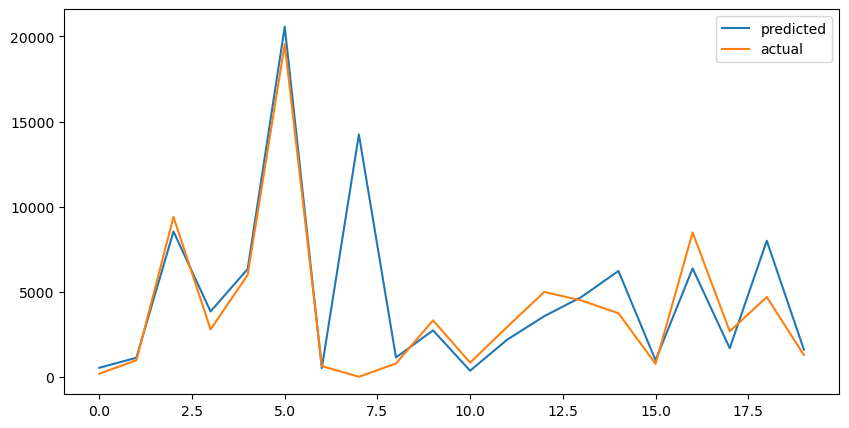

In [64]:
#plot for predicted and actual price 
plt.figure(figsize=(10,5))
plt.plot(Y_pred[0:20])
plt.plot(np.array(Y_test[0:20]))
plt.legend(["predicted","actual"])
plt.show()

In [65]:
print("The accuracy of the RandomForestRegression:",r2)

The accuracy of the RandomForestRegression: 0.0003170465263528932
